In [1]:
import os
import numpy as np
import pandas as pd
from flip import fitter, plot_utils
from flip.covariance import covariance, contraction
from pkg_resources import resource_filename
flip_base = resource_filename("flip", ".")
data_path = os.path.join(flip_base, "data")

[ 000000.00 ]: 12-22 06:36  root            INFO     No pypower module detected, gridding with this method is unavailable
[ 000001.18 ]: 12-22 06:36  jax._src.xla_bridge INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[ 000001.19 ]: 12-22 06:36  jax._src.xla_bridge INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[ 000001.19 ]: 12-22 06:36  jax._src.xla_bridge INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
[ 000001.19 ]: 12-22 06:36  jax._src.xla_bridge WARNING  An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/tmp/ipykernel_1209545/165906352.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import re

In [2]:
grid = pd.read_parquet(os.path.join(data_path,"density_data.parquet"))
grid_window = pd.read_parquet(os.path.join(data_path,"grid_window_m.parquet"))

coordinates_density = np.array([grid["ra"], grid["dec"], grid["rcom"]])
data_density = {'density': np.array(grid["density"]), 
                'density_error': np.array(grid["density_err"])}


ktt, ptt = np.loadtxt(os.path.join(data_path,"power_spectrum_tt.txt"))
kmt, pmt = np.loadtxt(os.path.join(data_path,"power_spectrum_mt.txt"))
kmm, pmm = np.loadtxt(os.path.join(data_path,"power_spectrum_mm.txt"))

sigmag_fiducial = 3.0

power_spectrum_dict_bias = {"gg": [[kmm, pmm * np.array(grid_window["window_mm"])**2]]}
power_spectrum_dict = {"gg": [[kmm, pmm * np.array(grid_window["window_mm"])**2],
                              [kmt, pmt * np.array(grid_window["window_mt"])],
                              [ktt, ptt]]}


# Fit Bias

In [3]:
size_batch=10_000
number_worker=1

covariance_bias = covariance.CovMatrix.init_from_flip(
    "adamsblake17plane",
    "density",
    power_spectrum_dict_bias,
    coordinates_density=coordinates_density,
    size_batch=size_batch,
    number_worker=number_worker,
)

[ 000000.89 ]: 12-22 06:36  root            INFO     Covariance matrix generated from flip with adamsblake17plane model in 6.38e-01 seconds


In [4]:
likelihood_type_bias="multivariate_gaussian"
likelihood_properties_bias = {"inversion_method": "cholesky"}


parameter_dict_bias = {"bs8": {"value": 1.0,
                          "limit_low" : 0.0,
                          "limit_up" : 20.0,
                          "fixed" : False,
                         },
                 }


minuit_fitter_bias = fitter.FitMinuit.init_from_covariance(
        covariance_bias,
        data_density,
        parameter_dict_bias,
        likelihood_type=likelihood_type_bias,
        likelihood_properties = likelihood_properties_bias
)

minuit_fitter_bias.run()

[ 000001.00 ]: 12-22 06:36  root            INFO     Iteration 1/1

[ 000002.47 ]: 12-22 06:36  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1528                       │              Nfcn = 18               │
│ EDM = 2.84e-08 (Goal: 0.0002)    │            time = 1.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴───────

# Fit fs8 

### the measured value is false because an oversimplified example is used

In [5]:
size_batch=10_000
number_worker=8

covariance_fit = covariance.CovMatrix.init_from_flip(
    "adamsblake20",
    "density",
    power_spectrum_dict,
    coordinates_density=coordinates_density,
    size_batch=size_batch,
    number_worker=number_worker,
    additional_parameters_values=(sigmag_fiducial,),
)


[ 000003.44 ]: 12-22 06:36  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 9.71e-01 seconds


In [6]:
likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "inverse"}

parameter_dict = {"bs8": {"value": minuit_fitter_bias.minuit.values["bs8"],
                          "fixed" : True,
                         },
                  "fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "limit_up" : 1.0,
                          "fixed" : False,
                         },
                 }




minuit_fitter = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        data_density,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties)

minuit_fitter.run()




/global/homes/r/ravouxco/.local/perlmutter/python-3.11/lib/python3.11/site-packages/iminuit/util.py:172: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
[ 000003.68 ]: 12-22 06:36  root            INFO     Iteration 1/1

[ 000010.44 ]: 12-22 06:37  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1527                       │              Nfcn = 18               │
│ EDM = 1.23e-05 (Goal: 0.0002)    │            time = 6.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Bel

# Some plots

In [7]:
import matplotlib.pyplot as plt
plt.style.use(os.path.join(data_path,"style.mplstyle"))

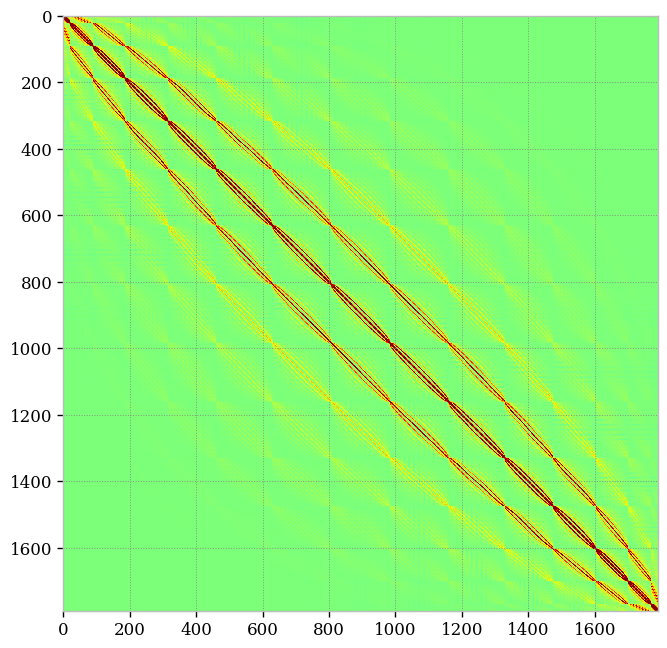

In [8]:
plot_utils.plot_correlation_from_likelihood(
    minuit_fitter.likelihood,
    parameter_dict,
)

In [9]:

r_perpendicular = np.linspace(-200,200,200)
r_parallel = np.linspace(-200,200,200)

r_reference_parallel = 30 
r_reference_perpendicular = 0 

contraction_plot = contraction.Contraction.init_from_flip(
    "adamsblake20",
    "density",
    power_spectrum_dict,
    r_perpendicular,
    r_parallel,
    r_reference_perpendicular,
    r_reference_parallel,
    coordinate_type="rprt",
    additional_parameters_values=(sigmag,),
)

parameter_values_dict = {parameters: parameter_dict[parameters]["value"] for parameters in parameter_dict}


plot_utils.plot_2d_contraction(contraction_plot, 
                    parameter_values_dict, 
                    rs_multiplied = True)


NameError: name 'sigmag' is not defined